Second sandbox. This one uses different dataset from the first. Columns are anonymous, and have already been through PCA. Tests using `MLPClassifier` were inconclusive.
- with certain seeds, `train_test_split` gives data that confuses the classifier
- classifier also suffers from some kind of overfitting issues

# Imports and setup

In [161]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [163]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')
print(df.columns)
print(df['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [164]:
X_all = df[df.columns[:-1]].values
y_all = df['Class'].values

# Helper functions

In [165]:
def fit_with_size(X_sample, y_sample, seed, train_size, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample,
        train_size=train_size,
        stratify=y_sample,
        random_state=seed  # make less random
    )

    if verbose:
        print("Fitting model with", train_size, "of the data...", end=' ')
        start_time = time()
    np.random.seed(seed)  # make less random
    model = MLPClassifier().fit(X_train, y_train)
    if verbose:
        end_time = time()
        print("done in", round(end_time-start_time), "seconds.")

    return model, X_test, y_test

In [166]:
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

In [151]:
def plot_metrics(df):
    plt.subplot(1, 3, 1)
    df["Precision"].plot.barh()
    plt.title("Precision")
    plt.subplot(1, 3, 2)
    df["Recall"].plot.barh()
    plt.title("Recall")
    plt.subplot(1, 3, 3)
    df["F1"].plot.barh()
    plt.title("F1")

# Bootstrapping a Neural Net

In [181]:
# https://www.kdnuggets.com/2023/03/bootstrapping.html
def bootstrap(X, y, n_samples, train_size):
    results = []
    for i in tqdm(range(n_samples)):
        run = {}
        np.random.seed(i)  # make less random
        indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_sample = X[indices, :]
        y_sample = y[indices]

        model, X_test, y_test = fit_with_size(X_sample, y_sample, i, train_size)
        precision, recall, f1 = get_metrics(model, X_test, y_test)

        run["Seed"] = i
        run["Precision"] = precision
        run["Recall"] = recall
        run["F1"] = f1
        run["Indices"] = indices
        run["Model"] = model
        results.append(run)
    return pd.DataFrame(results)

In [183]:
pred_df = bootstrap(X_all, y_all, 10, 0.2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.06s/it]


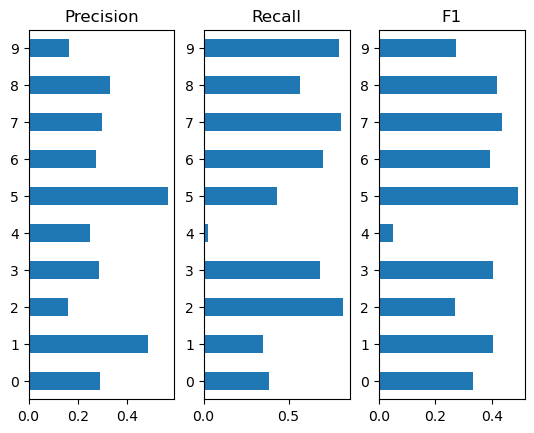

In [190]:
plot_metrics(pred_df)

# Majority voting

In [199]:
def weighted_predict(X, y, df, weight_by=None):
    n = y.shape
    y_weighted = np.zeros(n)
    all_predictions = []
    all_metrics = []
    
    models = df['Model'].values
    if weight_by is None:
        weights = [1 for _ in range(n)]
    else:
        weights = df[weight_by].values

    print("Making predictions...")
    for model, weight in tqdm(zip(models, weights)):
        y_raw = model.predict(X)
        all_predictions.append(y_raw)  # save this off for later comparison
        y_pred = y_raw * 2 - 1  # transform to range [-1, 1]
        y_pred = y_pred * weight
        y_weighted += y_pred
    # predictions are now in a range such that:
    # y >= 0 means a positive classification
    # y < 0 means a negative classification
    y_weighted = y_weighted >= 0
    all_predictions.append(y_weighted)

    print("Getting metrics...")
    for prediction in tqdm(all_predictions):
        d = {}
        d["Precision"] = precision_score(y, prediction)
        d["Recall"] = recall_score(y, prediction)
        d["F1"] = f1_score(y, prediction)
        all_metrics.append(d)

    print("Done.")
    return pd.DataFrame(all_metrics)

In [201]:
weight_df = weighted_predict(X_all, y_all, pred_df, 'F1')

Making predictions...


10it [00:04,  2.49it/s]


Getting metrics...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]

Done.


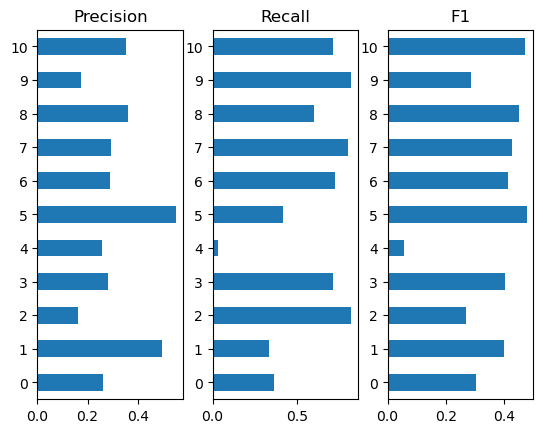

In [202]:
plot_metrics(weight_df)

# Experiments with `train_size`

In [205]:
pred_df.sort_values(by="F1", ascending=False).head()

,Seed,Precision,Recall,F1,Indices,Model
5,5,0.564356,0.434010,0.490674,"[18638, 20463, 124605, 232422, 136592, 33800, ...",MLPClassifier()
7,7,0.299814,0.805000,0.436906,"[61615, 189636, 49689, 10742, 235075, 79463, 1...",MLPClassifier()
8,8,0.331754,0.566038,0.418327,"[70083, 25940, 149489, 256361, 231557, 236371,...",MLPClassifier()
1,1,0.486486,0.346154,0.404494,"[128037, 267336, 73349, 117583, 21440, 229520,...",MLPClassifier()
3,3,0.286464,0.682500,0.403548,"[71530, 198296, 77049, 48056, 11261, 215699, 2...",MLPClassifier()


In [207]:
# Get the indices of the data that yielded the best results from the sampling
best_idx = pred_df.sort_values(by="F1", ascending=False).index[0]
bootstrapped_idx = pred_df.iloc[best_idx]["Indices"]
bootstrapped_seed = pred_df.iloc[best_idx]["Seed"]

X_sample = X_all[bootstrapped_idx, :]
y_sample = y_all[bootstrapped_idx]

In [209]:
training = []
sizes = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
for s in sizes:
    t = fit_with_size(X_sample, y_sample, bootstrapped_seed, s, verbose=True)
    training.append(t)

Fitting model with 0.1 of the data... done in 6 seconds.
Fitting model with 0.2 of the data... done in 14 seconds.
Fitting model with 0.3 of the data... done in 38 seconds.
Fitting model with 0.4 of the data... done in 14 seconds.
Fitting model with 0.5 of the data... done in 259 seconds.
Fitting model with 0.6 of the data... done in 107 seconds.
Fitting model with 0.7 of the data... done in 199 seconds.
Fitting model with 0.8 of the data... done in 89 seconds.


In [210]:
metrics = []
for t in training:
    m = {}
    model, X_test, y_test = t
    precision, recall, f1 = get_metrics(model, X_test, y_test)
    m["Precision"] = precision
    m["Recall"] = recall
    m["F1"] = f1
    metrics.append(m)
df_metrics = pd.DataFrame(metrics)
df_metrics["Size"] = sizes

C:\Users\ethan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


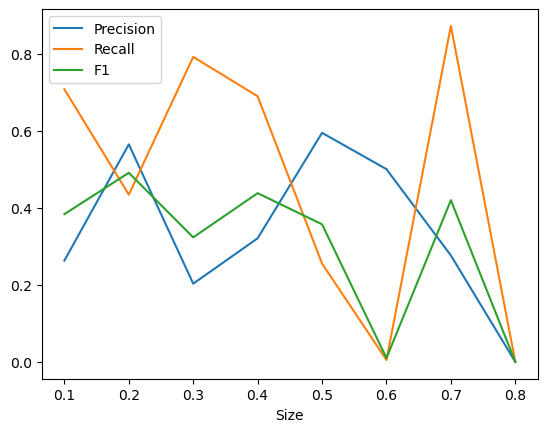

In [211]:
ax = df_metrics.plot(x="Size", y="Precision")
df_metrics.plot(x="Size", y="Recall", ax=ax)
df_metrics.plot(x="Size", y="F1", ax=ax)
_ = plt.legend()